In [113]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from tqdm import tnrange
sns.set_style('dark')
%matplotlib inline
import math
import torchvision.datasets
from torch.utils.data import Dataset
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)
from scipy.stats import norm
import scipy as sc

In [175]:
# Model
n_seq=8
class VAE(nn.Module):
    def __init__(self,n_seq=8,latent_dim=2,hidden_dim=10):
        super(VAE,self).__init__()
        self.n_seq=n_seq
        self.fc_e = nn.Linear(self.n_seq**2,hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.fc_d1 = nn.Linear(latent_dim,hidden_dim)
        self.fc_d2 = nn.Linear(hidden_dim,self.n_seq**2)
            
    def encoder(self,x_in):
        x = F.relu(self.fc_e(x_in.view(-1,self.n_seq**2)))
        mean = self.fc_mean(x) # mean values for z 
        logvar = self.fc_logvar(x) # variance values z  
        return mean, logvar
    
    def decoder(self,z):
        z = F.relu(self.fc_d1(z))
        x_out = F.sigmoid(self.fc_d2(z))
        return x_out.view(-1,self.n_seq,self.n_seq)
    
    def sample_normal(self,mean,logvar):
        # Using torch.normal(means,sds) returns a stochastic tensor which we cannot backpropogate through.
        # Instead we utilize the 'reparameterization trick'.
        # http://stats.stackexchange.com/a/205336
        # http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf
        sd = torch.exp(logvar*0.5)
        e = Variable(torch.randn(sd.size(),device=device)) # Sample from standard normal
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x_in):
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean,z_logvar)
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar

model = VAE()
model.to(device)

VAE(
  (fc_e): Linear(in_features=64, out_features=10, bias=True)
  (fc_mean): Linear(in_features=10, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=10, out_features=2, bias=True)
  (fc_d1): Linear(in_features=2, out_features=10, bias=True)
  (fc_d2): Linear(in_features=10, out_features=64, bias=True)
)

64

In [176]:
# Loss function
def criterion(x_out,x_in,z_mu,z_logvar):
    bce_loss = F.binary_cross_entropy(x_out,x_in,size_average=False)
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
    loss = (bce_loss + kld_loss) / x_out.size(0) # normalize by batch size
    return loss.to(device)

In [177]:
optimizer = torch.optim.Adam(model.parameters())

In [178]:
# create a dataset of p(n,m)
# create a batch version of the dataset 
class diss_data(Dataset):
    def __init__(self, n_dim=10,n_seq=8,n_samples=2000*30):
        self.n_dim=n_dim
        self.n_samples = n_samples
        # 
        self.n_seq=n_seq
        self.p_n_m =self.create_p_n_m()

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        
        return self.p_n_m[idx].float()
    
    def create_p_n_m(self):
        d_cell=[np.random.rand(self.n_seq,self.n_dim) for x in range(self.n_samples)]
        d_sq=[sc.spatial.distance.squareform(sc.spatial.distance.pdist(x)) for x in d_cell]
        func = lambda x: np.multiply(norm.cdf(x/np.sqrt(2)),norm.cdf(x/(2)))+np.multiply(norm.cdf(-x/np.sqrt(2)),norm.cdf(-x/(2)))
        p_ij = [func(x) for x in d_sq]
        p_ij_tens=[torch.tensor(x) for x in p_ij]
        p_n_m=torch.stack(p_ij_tens)
        return p_n_m

torch.Size([60000, 8, 8])

In [179]:
dissimilarity_data=diss_data()
trainloader = torch.utils.data.DataLoader(
    dataset=dissimilarity_data,
    batch_size=30,
    shuffle=True)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

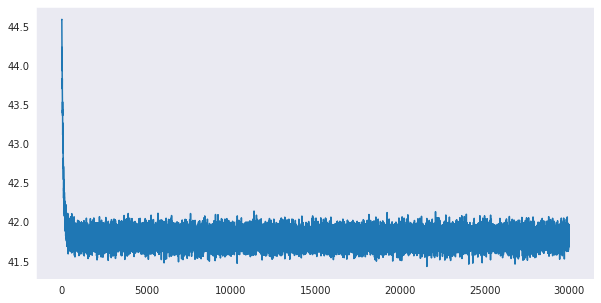

In [180]:
# Training
def train(model,optimizer,dataloader,epochs=15):
    losses = []
    for epoch in tnrange(epochs,desc='Epochs'):
        for images in dataloader:
            x_in = images
            x_in=x_in.to(device)
            optimizer.zero_grad()
            x_out, z_mu, z_logvar = model(x_in)
            loss = criterion(x_out,x_in,z_mu,z_logvar)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.data.item())
    return losses

train_losses = train(model,optimizer,trainloader)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

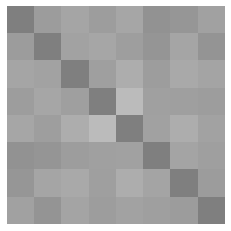

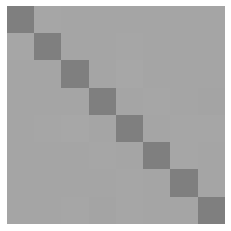

In [181]:
# Visualize VAE input and reconstruction
def visualize_mnist_vae(model,dataloader,num=1):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = Variable(images)
    x_in=x_in.to(device)
    x_out,_,_ = model(x_in)
    x_out = x_out.data
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out.cpu()))

visualize_mnist_vae(model,trainloader)

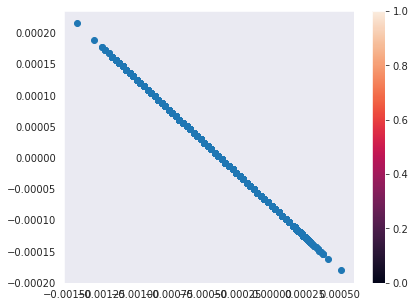

In [182]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images in iter(dataloader):
        z_means,_ = model.encoder(Variable(images).to(device))
        z_means_x = np.append(z_means_x,z_means[:,0].data.cpu().numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.cpu().numpy())

        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model,trainloader)

In [183]:
z_means

NameError: name 'z_means' is not defined

In [122]:
z_mu_list=[]
z_logvar_list=[]
for images in trainloader:
    x_in = images
    x_in=x_in.to(device)
    with torch.no_grad():
        x_out, z_mu, z_logvar = model(x_in)
    z_mu_list.append(z_mu)
    z_logvar_list.append(z_logvar)

In [123]:
torch.stack(z_logvar_list)

tensor([[[ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         ...,
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05]],

        [[ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         ...,
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05]],

        [[ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         [ 2.8223e-04, -9.9001e-04, -2.2578e-04, -9.9172e-05],
         ...,
         

In [157]:
# Visualize digits generated from latent space grid
def visualize_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*n_seq,num*n_seq])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = Variable(torch.FloatTensor([[x,y]]))
            image = model.decoder(z.to(device))
            image = image.data.numpy()
            image_grid[(j*n_seq):((j+1)*n_seq),(i*n_seq):((i+1)*n_seq)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid)
    plt.show()

visualize_decoder(model)

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [184]:
num=4
range_type='g'
image_grid = np.zeros([num*n_seq,num*n_seq])

if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
    range_space = np.linspace(-4,4,num)
elif range_type == 'g': # gaussian range
    range_space = norm.ppf(np.linspace(0.01,0.99,num))
else:
    range_space = range_type

for i, x in enumerate(range_space):
    for j, y in enumerate(reversed(range_space)):
        z = Variable(torch.FloatTensor([[x,y]]))
        image = model.decoder(z.to(device))
        image = image.data.cpu().numpy()
        image_grid[(j*n_seq):((j+1)*n_seq),(i*n_seq):((i+1)*n_seq)] = image



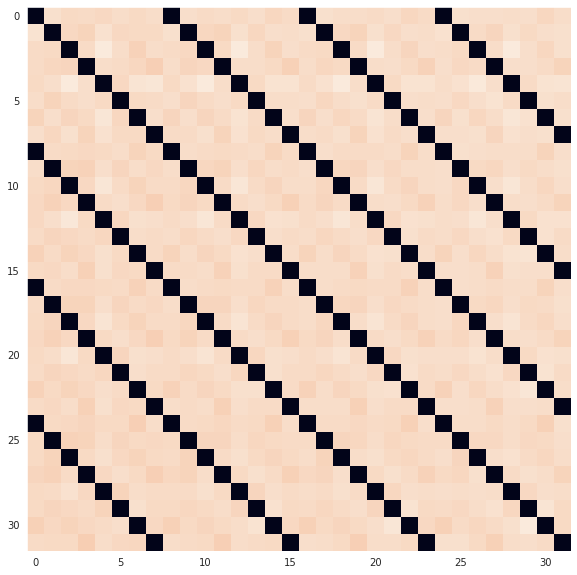

In [188]:
plt.figure(figsize=(10, 10))
plt.imshow(image_grid)
plt.show()